ここではkaggleで開催されたコンペのデータを元に回帰モデルを実装。<br>
予測をしていきます。<br>
<br>
データ元：https://www.kaggle.com/c/ashrae-energy-prediction/overview<br>
2021年現在でもデータは利用できるので、初学者向けの教材にもなっています。

## ライブラリのインポート

In [1]:
import os
import glob
import gc
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

%matplotlib inline

In [2]:
# 分析で使うファイルの一覧
dir = './'

filenames = glob.glob(dir + '/*.csv')

for filename in filenames:
    print(os.path.join(dir, filename))

./.\building_metadata.csv
./.\sample_submission.csv
./.\test.csv
./.\train.csv
./.\weather_test.csv
./.\weather_train.csv


sample_submissionはKaggleに予測結果を提出するものなので、<br>
手元で使うのは残り5つのデータになります。

## データの読み込み

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
weather_train = pd.read_csv('weather_train.csv')
weather_test = pd.read_csv('weather_test.csv')
meta = pd.read_csv('building_metadata.csv')

※メモリの都合上、ここではなるべくhead()は使いません。

今回の目的変数は、教師データの「meta_reading」(エネルギー使用量)です。<br>
さらに「１時間ごとのメータ情報(train.csv)」と「天気情報(weather)」と「メータの設置されているビル（meta）」にデータが分かれています。<br>
これらをまずは結合していきます。

In [4]:
# 表のマージ
# ビル情報は教師データとテストデータで共通
train = train.merge(meta, on='building_id', how='left')
test = test.merge(meta, on='building_id', how='left')

無事結合できているので、続いては天気の表も共通カラムをベースに結合していきます。

In [5]:
# 結合して表示
train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')

In [6]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [7]:
# データのサイズを確認
print(train.shape,test.shape)

(20216100, 16) (41697600, 16)


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   building_id         int64  
 1   meter               int64  
 2   timestamp           object 
 3   meter_reading       float64
 4   site_id             int64  
 5   primary_use         object 
 6   square_feet         int64  
 7   year_built          float64
 8   floor_count         float64
 9   air_temperature     float64
 10  cloud_coverage      float64
 11  dew_temperature     float64
 12  precip_depth_1_hr   float64
 13  sea_level_pressure  float64
 14  wind_direction      float64
 15  wind_speed          float64
dtypes: float64(10), int64(4), object(2)
memory usage: 2.6+ GB


timestampは時系列データなので、時系列型に変換しておきます。

In [9]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

## EDA

ここからはモデル構築の前に、データ探索をして特徴を掴んでいきます。<br>
さらに途中で必要な処理もしていきたいと思います。

### 欠損値の穴埋め

In [10]:
# 欠損値の確認
N_null = []

for i in train.columns:
    null = train[i].isnull().sum()
    N_null.append(null)
    print(N_null[-1])

0
0
0
0
0
0
0
12127645
16709167
96658
8825365
100140
3749023
1231669
1449048
143676


データの真ん中あたりからかなり欠損があることがわかります。<br>
欠損地の割合によってはデータとして使えないので、欠損の割合をそれぞれ算出します。

In [11]:
# カラムごとの欠損の割合
for i in train.columns[7:]:
    null = train[i].isnull().sum()
    rate = null / len(train[i])
    print(train[i].name,rate)

year_built 0.5999003269671203
floor_count 0.826527718006935
air_temperature 0.004781238715677109
cloud_coverage 0.43655131306236117
dew_temperature 0.00495347767373529
precip_depth_1_hr 0.18544739094088375
sea_level_pressure 0.06092515371411895
wind_direction 0.0716779200736047
wind_speed 0.007107008770237583


今回は10％以上の欠損があるものは精度が悪くなるため、扱わないようにします。<br>
その他は欠損を中央値で穴埋めして、利用していきます。<br>
year_built,floor_count,cloud_coverageなどは使用しません。 

In [12]:
# メモリをいったん開放
del N_null
del null
del rate
gc.collect()

34

In [13]:
# 欠損の穴埋め
train['air_temperature'] = train['air_temperature'].fillna(train['air_temperature'].median())
train['dew_temperature'] = train['dew_temperature'].fillna(train['dew_temperature'].median())
train['sea_level_pressure'] = train['sea_level_pressure'].fillna(train['sea_level_pressure'].median())
train['wind_direction'] = train['wind_direction'].fillna(train['wind_direction'].median())
train['wind_speed'] = train['wind_speed'].fillna(train['wind_speed'].median())

In [14]:
#testも同様に処理
test['air_temperature'] = test['air_temperature'].fillna(test['air_temperature'].median())
test['dew_temperature'] = test['dew_temperature'].fillna(test['dew_temperature'].median())
test['sea_level_pressure'] = test['sea_level_pressure'].fillna(test['sea_level_pressure'].median())
test['wind_direction'] = test['wind_direction'].fillna(test['wind_direction'].median())
test['wind_speed'] = test['wind_speed'].fillna(test['wind_speed'].median())

In [15]:
# 欠損を含む使わないデータの削除
train = train.dropna(axis=1)
test = test.dropna(axis=1)

### 時系列によるエネルギー使用量

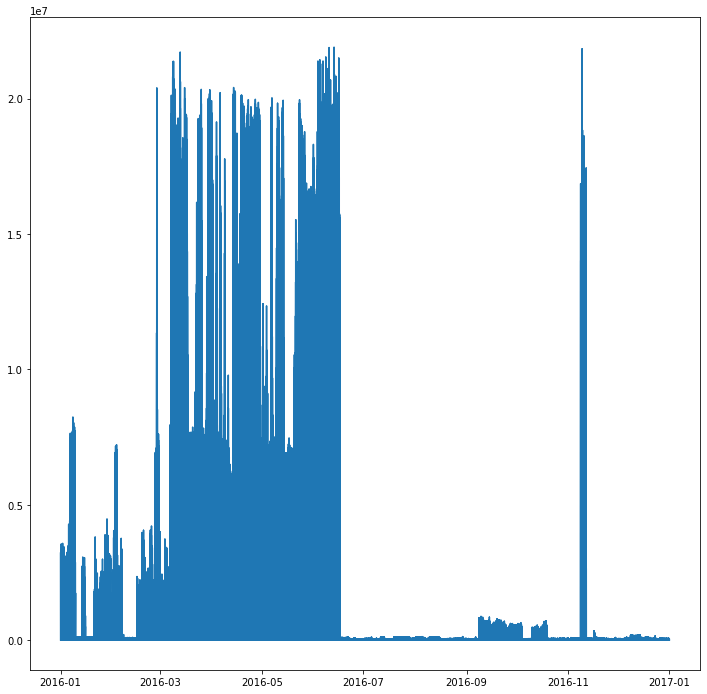

In [16]:
# 時間経過とエネルギー使用量の推移
plt.figure(figsize=(12,12))
plt.plot(train['timestamp'],train['meter_reading'])
plt.show()

時系列でかなり特徴が出ているのがわかります。<br>
季節というのは重要な特徴量になりそうです。<br>
なので、「●月」という情報をテーブルに追加します

In [17]:
# 月のデータを追加
train['month'] = train['timestamp'].dt.strftime("%m")
test['month'] = test['timestamp'].dt.strftime("%m")

<AxesSubplot:xlabel='meter_reading', ylabel='month'>

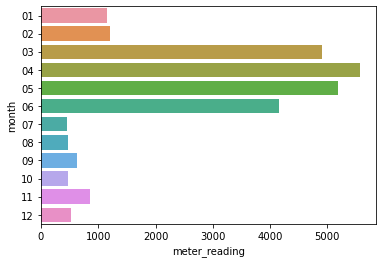

In [18]:
# 月ごとのエネルギー使用量
month_use = train.groupby("month").meter_reading.mean()
sns.barplot(y=month_use.index,x=month_use)

In [19]:
# エネルギー使用量の基本統計量
train['meter_reading'].describe()

count    2.021610e+07
mean     2.117121e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

エネルギーは、floatでで測定されています。<br>
これを予測するモデルが必要になります。

### エネルギー使用目的による差

In [20]:
# メータを文字列としてマップ
#データの説明では用途別にイントで格納されています。
meter = {0:'hotwater', 1:'chilledwater', 2:'steam', 3:'electricity'}
train['meter'] = train['meter'].map(meter)
test['meter'] = test['meter'].map(meter)

In [21]:
train['meter'].value_counts()

hotwater        12060910
chilledwater     4182440
steam            2708713
electricity      1264037
Name: meter, dtype: int64

<AxesSubplot:xlabel='meter', ylabel='count'>

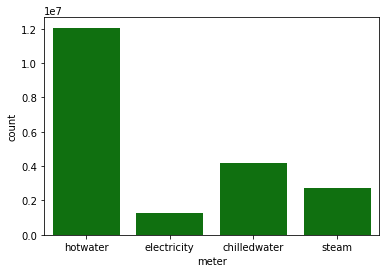

In [22]:
sns.countplot(x= "meter",data = train,color = 'g')

エネルギーの使用目的も特徴量としては重要な要素になりそうです。<br>
使用目的にはもう一つあり、primary_useという主目的の項目があります。

<AxesSubplot:xlabel='primary_use', ylabel='count'>

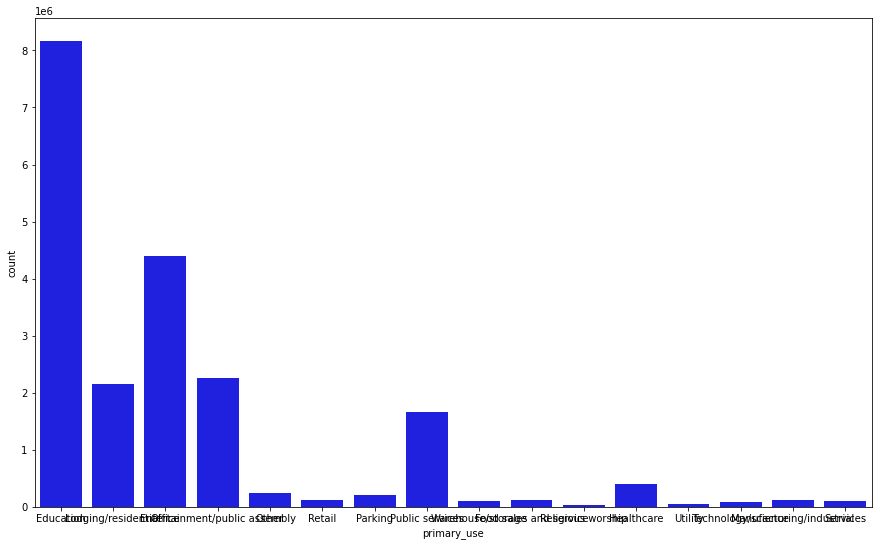

In [23]:
plt.figure(figsize=(15,9))
sns.countplot(x = 'primary_use',data = train, color='b')

<AxesSubplot:xlabel='primary_use', ylabel='meter_reading'>

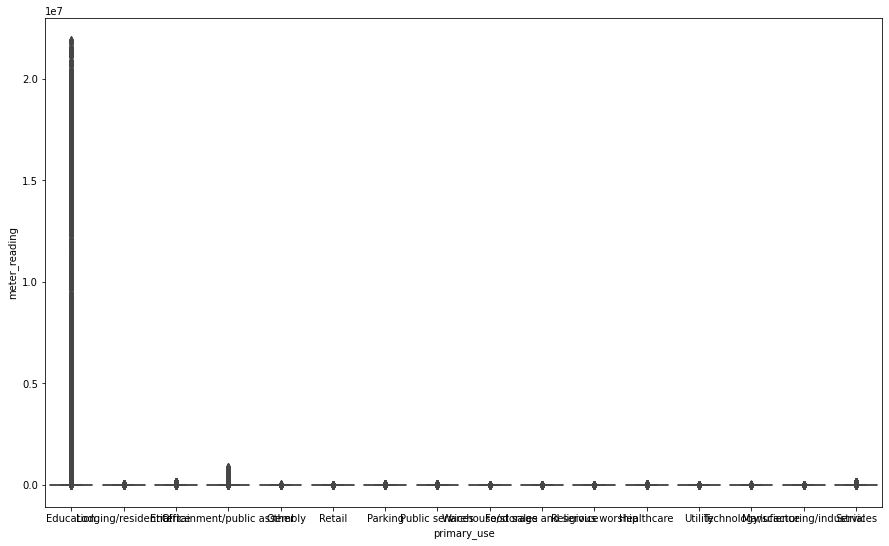

In [24]:
plt.figure(figsize=(15,9))
sns.boxplot(x = 'primary_use', data = train, y = 'meter_reading')

特徴量としては多いですが、**目的によって使用量が違う**ことがわかります。<br>
これも特徴量としては使えそうです。

### 数値データの相関係数

<AxesSubplot:>

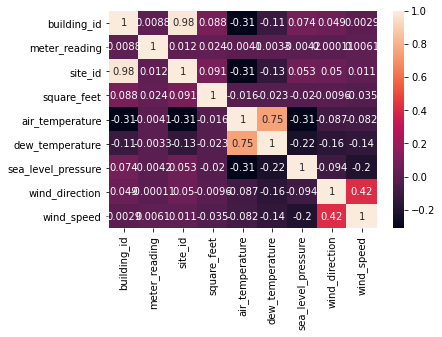

In [25]:
# 相関係数の測定と可視化
train_corr = train.corr()
sns.heatmap(train_corr, annot=True)

使用量と関係ありそうなものを見ていきます。<br>
しかし、意外なことに温度との相関関係があまりないように思います。<br>
おそらくは、気温は前日との差などが影響するのではないかと思います。<br>
なので、１週間前の気温差というのもデータに追加していきます。<br>

In [26]:
# 1時間ごとのデータなので、periods=168で一週間前のデータの差分で指定
# 欠損ができるので、穴埋めも行う
train['airtemperature_diff'] = train['air_temperature'].diff(periods=168)
train['airtemperature_diff'].describe()

count    2.021593e+07
mean    -1.266328e-04
std      8.712277e+00
min     -4.850000e+01
25%     -4.000000e+00
50%      0.000000e+00
75%      3.400000e+00
max      4.880000e+01
Name: airtemperature_diff, dtype: float64

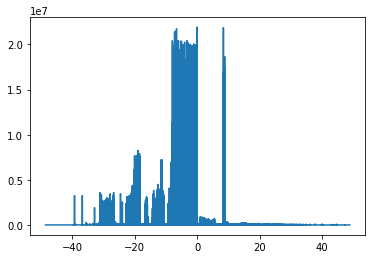

In [27]:
air_tem = train['airtemperature_diff'].sort_values(ascending=True)
plt.plot(air_tem,train['meter_reading'])

In [28]:
#差分を取るとNanができてしまうので中央値で穴埋め(テストデータも)
train['airtemperature_diff'] = train['airtemperature_diff'].fillna(train['airtemperature_diff'].median())
test['airtemperature_diff'] = test['air_temperature'].diff(periods=168)
test['airtemperature_diff'] = test['airtemperature_diff'].fillna(test['airtemperature_diff'].median())

In [29]:
# メモリの開放
del air_tem
del train_corr
gc.collect()

2580

ひとまずは上記の特徴量を元に説明変数を設定します。<br>
ここからはデータをモデルに入れられるように前処理をしていきます。<br>

## 前処理

In [30]:
train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'air_temperature', 'dew_temperature',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'month',
       'airtemperature_diff'],
      dtype='object')

In [42]:
# 説明変数の設定
x = train[['meter','primary_use', 'square_feet','sea_level_pressure','month','airtemperature_diff']]
y = train['meter_reading']
test_x = test[['meter','primary_use', 'square_feet','sea_level_pressure','month','airtemperature_diff']]

In [43]:
# ダミー変数化
#monthとprimary_useはオブジェクトデータなので、ダミー変数化が必要
x = pd.get_dummies(x)

MemoryError: Unable to allocate 308. MiB for an array with shape (2, 20216100) and data type float64

In [ ]:
# 訓練データとテストデータの分割
X_train,X_test,y_train,y_test = train_test_split(x,y, test_size=0.2,random_state=123)

## LightGBMによる予測

使う分析モデルはLightGBMを使用していきたいと思います。<br>

In [39]:
model = lgb.LGBMRegressor() # モデルのインスタンスの作成
model.fit(X_train, y_train) # モデルの学習

# テストデータの予測
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [44]:
#MSEとRMSE
print('訓練データのMSE/RMSE：', mean_squared_error(y_train,y_pred_train), np.sqrt(mean_squared_error(y_train,y_pred_train)))
print('訓練データのMSE/RMSE：', mean_squared_error(y_test,y_pred_test), np.sqrt(mean_squared_error(y_test,y_pred_test)))

MemoryError: Unable to allocate 123. MiB for an array with shape (16172880, 1) and data type float64